In [1]:
import tensorflow as tf
import ori_model as tm
import numpy as np
import math 
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
print(tf.VERSION) # seems to work fine with tf version 1.10, but failed with tf 1.13

1.10.0


preparing mask

In [3]:
def getMask(size=[128,128], porder = 5.0, bias = 0.1, acs = 3, seed = 0, axis_undersample=1, mute=0):
    # init
    mask = np.zeros(size)
    np.random.seed(seed)
    # gen random mask
    for i in range(size[1]):
        x = (i-size[1]/2.0)/(size[1]/2.0)
        p = np.random.rand() 
        if p <= abs(x)**porder + bias:
            if axis_undersample == 0:
                mask[i][:]=1
            else:
                mask[:][i]=1
    # acs                
    if axis_undersample == 0:
        mask[:int((acs+1)/2)][:]=1
        mask[-int(acs/2):][:]=1
    else:
        mask[:][:int((acs+1)/2)]=1
        mask[:][-int(acs/2):]=1

    # compute reduction
    r_factor = len(mask.flatten())/sum(mask.flatten())
    if not mute:
        print('gen mask for R-factor={0:.4f}'.format(r_factor))

    # use tf
    return mask, r_factor

mask, r_factor = getMask(size=[28,28], porder=5, acs = 3)
print(r_factor, np.where(mask[0,:]))

gen mask for R-factor=3.5000
3.5 (array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27]),)


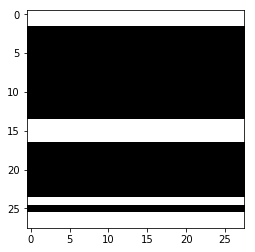

In [4]:
plt.imshow(mask, cmap = "gray")

get training data--mnist dataset

In [5]:
((train_data, train_labels),
 (eval_data, eval_labels)) = tf.keras.datasets.mnist.load_data()
train_data = train_data/np.float32(255)
eval_data = eval_data/np.float32(255)
mask = np.reshape(mask, [1, 28, 28])

In [6]:
def get_batch(size = 100):
    np.random.seed()
    batch_loc = np.random.randint(60000, size=size)
    train_bat_im = train_data[batch_loc]
    return np.reshape(train_bat_im,[size, 28, 28, 1])

def get_masked(data, mask):
    d_complex = tf.reshape(tf.cast(data, tf.complex64),
                           [data.shape[0], 28, 28])
    mask_complex = tf.cast(mask, tf.complex64)
    d_kspace = tf.fft2d(d_complex)*mask_complex
    d_masked_complex = tf.ifft2d(d_kspace)
    d_masked_real = tf.reshape(tf.real(d_masked_complex), 
                               [d_masked_complex.get_shape()[0], 28, 28, 1])
    d_masked_imag = tf.reshape(tf.imag(d_masked_complex), 
                               [d_masked_complex.get_shape()[0], 28, 28, 1])
    d_masked = tf.concat([d_masked_real, d_masked_imag], axis = 3)
    with tf.Session() as sess:
        masked = sess.run(d_masked)
    return masked

In [7]:
batch = get_batch()
masked = get_masked(batch, mask)

In [8]:
m1 = tf.cast(masked[15][:][:][:], tf.complex64)
re = m1[:,:,0]+1j*m1[:,:,1]
r = tf.abs(re)
r = tf.reshape(r, [28, 28])

In [9]:
with tf.Session() as sess:
    o1 = sess.run(r)

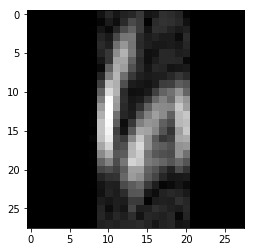

In [10]:
plt.imshow(o1, cmap = "gray")

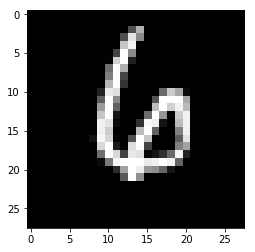

In [11]:
r1 = np.reshape(batch[15,:,:,:], [28, 28])
plt.imshow(r1, cmap = "gray")

preparing model structure

In [12]:
batchsize = 100 # change it along with test_model.py
model_input_masked = tf.placeholder(tf.float32, [batchsize, 28, 28, 2], 
                                    "masked")
model_input_gtrue = tf.placeholder(tf.float32, [batchsize, 28, 28, 1], 
                                   "ground_truth")


In [13]:
gene_output, gene_output_complex, gene_var_list, gene_layers, disc_real_output, disc_fake_output, disc_var_list, disc_layers = tm.create_model(model_input_masked, model_input_gtrue, mask)
    
    
gene_loss, gene_dc_loss, gene_fool_loss, list_gene_lose, gene_mse_factor = tm.create_generator_loss(disc_fake_output, gene_output, gene_output_complex, model_input_masked, model_input_gtrue, mask)
    
    
disc_loss = tm.create_discriminator_loss(disc_real_output, disc_fake_output)
    
global_step, learning_rate, gene_minimize, disc_minimize = tm.create_optimizers(gene_loss, gene_var_list,disc_loss, disc_var_list)
    
    

use resnet without pooling: [64, 64, 64]
using Fourier, input dim (100, 28, 28, 2), output dim (100, 28, 28)
using Fourier, input dim (100, 28, 28, 2), output dim (100, 28, 28)
use resnet without pooling: [64, 64, 64]
using Fourier, input dim (100, 28, 28, 2), output dim (100, 28, 28)
using Fourier, input dim (100, 28, 28, 2), output dim (100, 28, 28)
use resnet without pooling: [64, 64, 64]
using Fourier, input dim (100, 28, 28, 2), output dim (100, 28, 28)
using Fourier, input dim (100, 28, 28, 2), output dim (100, 28, 28)
use resnet without pooling: [64, 64, 64]
using Fourier, input dim (100, 28, 28, 2), output dim (100, 28, 28)
using Fourier, input dim (100, 28, 28, 2), output dim (100, 28, 28)
use resnet without pooling: [64, 64, 64]
using Fourier, input dim (100, 28, 28, 2), output dim (100, 28, 28)
using Fourier, input dim (100, 28, 28, 2), output dim (100, 28, 28)
use resnet without pooling: [64, 64, 64]
using Fourier, input dim (100, 28, 28, 2), output dim (100, 28, 28)
using 

In [14]:
import time

def train_process(epochs = 20, batch_size = 100):
    gene_train_log = []
    disc_train_log = []
    train_time = 0
    while train_time<epochs:
        start_time = time.time()
        batch_true = get_batch(batch_size)
        batch_masked = get_masked(batch_true, mask)
        g_los, d_los = sess.run([gene_loss, disc_loss],feed_dict = {model_input_masked:batch_masked, model_input_gtrue:batch_true, learning_rate: 0.001})
        #print('done with loss')
        gene_train_log.append(g_los)
        disc_train_log.append(d_los)
        sess.run([gene_minimize,disc_minimize],feed_dict = {model_input_masked:batch_masked, model_input_gtrue:batch_true, learning_rate: 0.001})
        print("epoch: "+str(train_time)+", g_loss: "+str(g_los)+", d_loss: "+str(d_los)+" time_spent:"+str(time.time()-start_time)+"s")
        train_time += 1
    return (gene_train_log, disc_train_log)

In [15]:
sess = tf.Session()
init = tf.global_variables_initializer()
writer = tf.summary.FileWriter("logs/", sess.graph)
sess.run(init)

In [16]:
g_log, d_log = train_process(epochs = 5)

epoch: 0, g_loss: 86.01013, d_loss: 0.50793153 time_spent:52.70038318634033s
epoch: 1, g_loss: 71.818245, d_loss: 0.46714363 time_spent:33.21795892715454s
epoch: 2, g_loss: 61.806034, d_loss: 0.41532868 time_spent:33.212024211883545s
epoch: 3, g_loss: 54.294468, d_loss: 0.3853618 time_spent:33.05498266220093s
epoch: 4, g_loss: 45.03663, d_loss: 0.3734278 time_spent:33.175880670547485s


In [18]:
saver=tf.train.Saver(max_to_keep=1)
pa = saver.save(sess,"/home/charlieniu21/code/GANCS/model/mnist_5.ckpt")

In [42]:
sess = tf.Session()
model_file=tf.train.latest_checkpoint('/home/charlieniu21/code/GANCS/model/')
saver.restore(sess, model_file)

INFO:tensorflow:Restoring parameters from /home/charlieniu21/code/GANCS/model/mnist_5.ckpt


In [17]:
o2 = sess.run(gene_output,feed_dict = {model_input_masked:masked, model_input_gtrue:batch, learning_rate: 0.001})

In [44]:
o2.shape

(100, 28, 28, 1)

In [18]:
m = o2[15,:,:,:]

In [19]:
m.shape

(28, 28, 1)

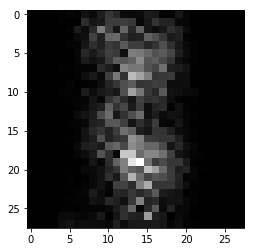

In [20]:
m = np.reshape(m, [28, 28])
plt.imshow(m, cmap = "gray")

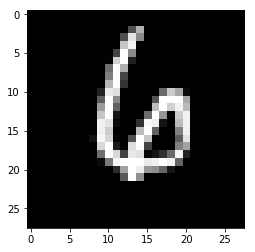

In [21]:
g = batch[15,:,:,:]
g = np.reshape(g, [28, 28])
plt.imshow(g, cmap = "gray")

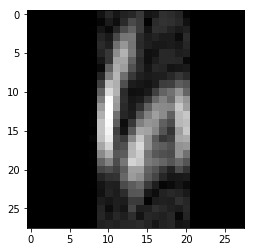

In [23]:
m1 = tf.cast(masked[15][:][:][:], tf.complex64)
re = m1[:,:,0]+1j*m1[:,:,1]
r = tf.abs(re)
r = tf.reshape(r, [28, 28])
with tf.Session() as ses:
    o1 = ses.run(r)
plt.imshow(o1, cmap = "gray")